# Building X_train, X_test and y_train, y_test datasets

# Train an MLP, and run inference on testing data
### This is the continuation of `cloud_01_getAllData.ipynb` noteobok

After learning how to retrieve data from around the wells, we can start with the machine learning portion of the workflow. We have reduced the section that is still necessary from the previous notebook into a single cell. If you need to review that code please go to the `cloud_01_getAllData.ipynb` notebook. 

**In this notebook we will cover the following:**

0. Data Ingestion and Filtering (Extract seismic at wellbore)
1. Feature Engineering
2. Data Preparation for ML Model Training
3. Neural Network Model Training
4. Bootstrap Aggregation and Inference
5. Conclusions

**This notebook assumes your AWS Credentials have been configured correctly**

In [1]:
%%capture
%pip install s3fs==0.5.0
%pip install real-simple-seismic

In [2]:
from math import floor, ceil

from rss.client import rssFromS3
from pandas import concat, IndexSlice, read_csv, read_json

# Section 0. Data Ingestion and Filtering
### This section below is the same as in `cloud_01_getAllData.ipynb`
If you need to review the code please visit this notebook under tutorial section of the competition GitHub

In [3]:
%%time
well_bucket = 's3://sagemaker-gitc2021/poseidon/wells/'
well_file = 'poseidon_geoml_training_wells.json.gz'

well_df = read_json(
    path_or_buf=well_bucket + well_file,
    compression='gzip',
)

well_df.set_index(['well_id', 'twt'], inplace=True)

'''
Get well names and separate `DataFrame` per well, and put in a dictionary.
We also build inline / crossline ranges (min/max) for each well here. This will give us the range to
query from the seismic data.
'''
well_names = well_df.index.levels[0].to_list()
num_wells = len(well_names)

wells = {}
il_ranges = {}
xl_ranges = {}
for well_name in well_names:
    well = well_df.loc[well_name]
    well_ils_xls = well[['inline', 'xline']]
    il_xl_min = well_ils_xls.min()
    il_xl_max = well_ils_xls.max()

    wells[well_name] = well
    il_ranges[well_name] = floor(il_xl_min[0]), ceil(il_xl_max[0])
    xl_ranges[well_name] = floor(il_xl_min[1]), ceil(il_xl_max[1])

'''
Now, we need to extract seismic values around the wellbore. Let's start with
mounting `real-simple-seismic` volumes of interest so we can query later.
**Poseidon data vertical sampling is between 0 and 6,000 milliseconds.**
**Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.**
'''
seismic_bucket = r's3://sagemaker-gitc2021/poseidon/seismic/rss/'

seismic_files = [
    'psdn11_TbsdmF_Near_Nov_11_32bit',  # near angle stack (AVO)
    'psdn11_TbsdmF_Mid_Nov_11_32bit',  # mid angle stack (AVO)
    'psdn11_TbsdmF_Far_Nov_11_32bit',  # far angle stack (AVO)
    'Final_PSDM_intVel_gridded_D2T_10ms',  # PSDM interval velocities in time
]

'''
We loop through all files, and make connections to all four.
This takes about a minute.
The handles are later used for querying.
'''
rss_handles = []
for seismic_file in seismic_files:
    current_rss = rssFromS3(filename=seismic_bucket + seismic_file, client_kwargs={})

    rss_handles.append(current_rss)
    
from itertools import product
import numpy as np

# let's have nicer names for seismic data
seismic_names = ('near', 'mid', 'far', 'velocity')

well_seismic = {}
for well in wells.keys():
    il_min, il_max = il_ranges[well]
    xl_min, xl_max = xl_ranges[well]

    ils = range(il_min, il_max + 1, 1)  # inline increment is 1
    xls = range(xl_min, xl_max + 1, 1)  # xline increment is 1

    # Use product to have all il/xl pairs within our ranges
    ilxl_pairs = list(product(ils, xls))

    cube_data = {}
    # In rss, for minicube extraction we query trace by trace.
    for rss_handle, seismic_name in zip(rss_handles, seismic_names):
        tmp = []
        for trace_ilxl in ilxl_pairs:
            tmp.append(rss_handle.trace(*trace_ilxl)[0])  # rss returns values and a live mask, we don't need the mask now

        # Traces aren't in a "cube" shape, they come sequential. So we reshape!
        cube_data[seismic_name] = np.asarray(tmp).reshape(len(ils), len(xls), -1)

    well_seismic[well] = cube_data

Connection complete.
CPU times: user 17.7 s, sys: 3.4 s, total: 21.1 s
Wall time: 55.8 s


# Section 1. Feature Engineering

Let's begin with loading some libraries

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert, chirp
from sklearn.preprocessing import MinMaxScaler
sns.set(style="darkgrid")

# Tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow.keras as k

In this quick tutorial, we will extract **only** the near stack data for each well and save into independent variables. In the real application, we recommend you use near, mid, far stacks and velocity cubes as independent features. The rock properties we are predicting are physically related to differences between near, mid, and far stacks.

In [5]:
near_01 = well_seismic['well_01']['near']
near_11 = well_seismic['well_11']['near']
near_21 = well_seismic['well_21']['near']
near_25 = well_seismic['well_25']['near']
near_27 = well_seismic['well_27']['near']
near_33 = well_seismic['well_33']['near']

Now we will average all of the traces into one array. Let's stick these in a list for later processing. 

*This is not the ideal way to do this but it is the quickest and simplest way to generate a composite (i.e. wellbore extracted) trace. We recommend you do a weighted average around exact wellbore coordinates or interpolate values TO the wellbore coordinates. When wells are deviated, the averaging we are doing here is quite strong, we don't want to mix too many irrelevant data.*

In [6]:
# Average all IL/XL into a single array and create pd dataframes 
near_01_composite = pd.DataFrame(np.mean((np.mean(near_01,axis=1)), axis=0), columns=['near_01_composite'])
near_11_composite = pd.DataFrame(np.mean((np.mean(near_11,axis=1)), axis=0), columns=['near_11_composite'])
near_21_composite = pd.DataFrame(np.mean((np.mean(near_21,axis=1)), axis=0), columns=['near_21_composite'])
near_25_composite = pd.DataFrame(np.mean((np.mean(near_25,axis=1)), axis=0), columns=['near_25_composite'])
near_27_composite = pd.DataFrame(np.mean((np.mean(near_27,axis=1)), axis=0), columns=['near_27_composite'])
near_33_composite = pd.DataFrame(np.mean((np.mean(near_33,axis=1)), axis=0), columns=['near_33_composite'])

# Save into a list
composite_data = [near_01_composite, near_11_composite, near_21_composite, near_25_composite, near_27_composite, near_33_composite]

Let's plot all of the composites for a quick QC 

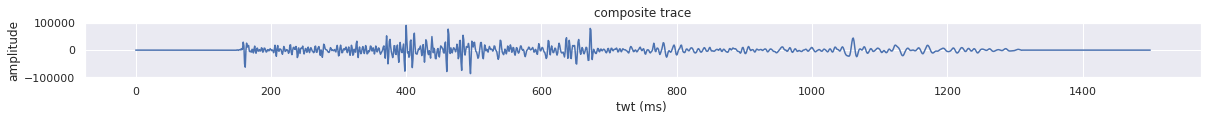

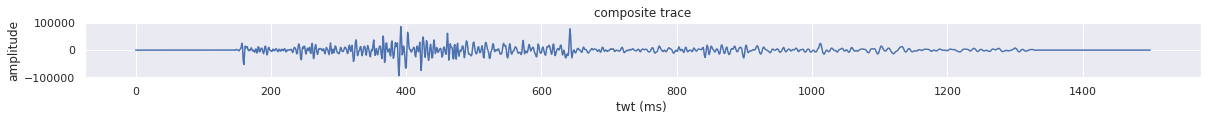

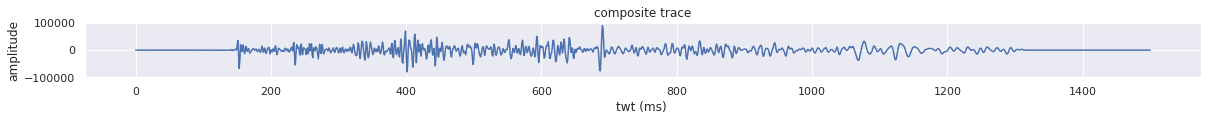

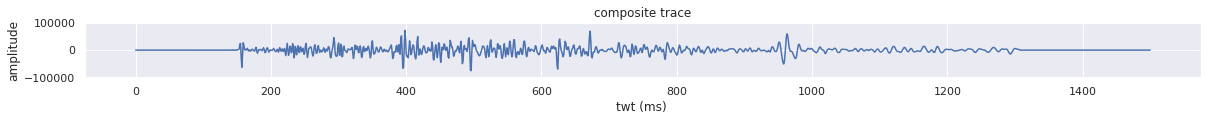

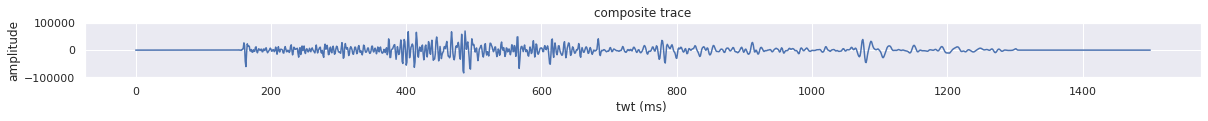

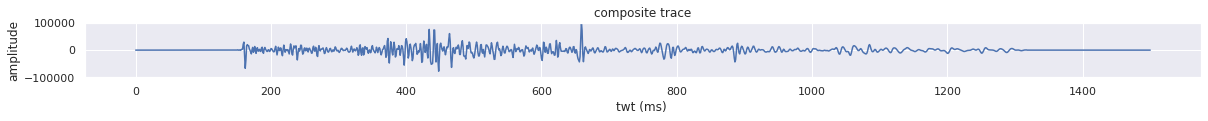

In [7]:
for composite in composite_data:
    plt.figure(figsize=(20,1))
    plt.plot(composite)
    plt.title('composite trace')
    plt.ylim(-100000,100000)
    plt.xlabel('twt (ms) ')
    plt.ylabel('amplitude')

Create the two-way-time indices for the training DataFrame.

We will interpolate seismic traces using `cubic` interpolation to the same sample rate as the well data, which is every 0.5 ms two-way-time.

If you recall:

*Poseidon data vertical sampling is between 0 and 6,000 milliseconds.*

*Seismic is sampled every 4 ms, and velocities are sampled every 10 ms.*


In [8]:
# index at 4ms 
seismic_twt = pd.DataFrame(np.arange(0, 6004.0, 4.0), columns=['twt'])

# index at .5 ms 
resamp_twt = pd.DataFrame(np.arange(0, 6000.5, 0.5), columns=['twt'])

In [9]:
# DataFrames to concatenate 
data_concat = [seismic_twt, near_01_composite, near_11_composite, near_21_composite, near_25_composite, near_27_composite, near_33_composite]
tt_seismic = pd.concat(data_concat, axis=1)

# Here we merge our seismic to the resamp 'twt' array
data_concat_resamp_raw = tt_seismic.merge(resamp_twt, how='right', on=['twt'])

# Here we interpolate the gaps in the seismic after the resamp
data_concat_resamp_interp = data_concat_resamp_raw.interpolate(method='cubic', limit_direction='forward', axis=0)

#let's look at the result
data_concat_resamp_interp

,twt,near_01_composite,near_11_composite,near_21_composite,near_25_composite,near_27_composite,near_33_composite
0,0.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
1,0.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
2,1.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
3,1.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
4,2.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
...,...,...,...,...,...,...,...
11996,5998.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
11997,5998.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
11998,5999.0,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084
11999,5999.5,-2.459141,-0.359645,-3.358005,-1.516816,-1.597808,-1.578084


Here we make a copy of wells to not corrupt the original dataframe.

In [10]:
near_01_composite_resamp = data_concat_resamp_interp[['twt','near_01_composite']].copy()
near_11_composite_resamp = data_concat_resamp_interp[['twt','near_11_composite']].copy()
near_21_composite_resamp = data_concat_resamp_interp[['twt','near_21_composite']].copy()
near_25_composite_resamp = data_concat_resamp_interp[['twt','near_25_composite']].copy()
near_27_composite_resamp = data_concat_resamp_interp[['twt','near_27_composite']].copy()
near_33_composite_resamp = data_concat_resamp_interp[['twt','near_33_composite']].copy()

In [11]:
well_01 = well_df.loc['well_01'].reset_index()
well_11 = well_df.loc['well_11'].reset_index()
well_21 = well_df.loc['well_21'].reset_index()
well_25 = well_df.loc['well_25'].reset_index()
well_27 = well_df.loc['well_27'].reset_index()
well_33 = well_df.loc['well_33'].reset_index()

Add appropriate targets P-Impedance (here, called Zp) and S-Impedance (here, called Zs). 

In [12]:
#calculate impedances and add to data 
# well_01
well_01['Zp'] = (1000000/well_01['dtc'])*well_01['rhob']
well_01['Zs'] = (1000000/well_01['dts'])*well_01['rhob']
# well_11
well_11['Zp'] = (1000000/well_11['dtc'])*well_11['rhob']
well_11['Zs'] = (1000000/well_11['dts'])*well_11['rhob']
# well_21
well_21['Zp'] = (1000000/well_21['dtc'])*well_21['rhob']
well_21['Zs'] = (1000000/well_21['dts'])*well_21['rhob']
# well_25
well_25['Zp'] = (1000000/well_25['dtc'])*well_25['rhob']
well_25['Zs'] = (1000000/well_25['dts'])*well_25['rhob']
# well_27
well_27['Zp'] = (1000000/well_27['dtc'])*well_27['rhob']
well_27['Zs'] = (1000000/well_27['dts'])*well_27['rhob']
# well_33
well_33['Zp'] = (1000000/well_33['dtc'])*well_33['rhob']
well_33['Zs'] = (1000000/well_33['dts'])*well_33['rhob']

In [13]:
# Lets filter the well data and keep only the relevant columns
well_01_stripped = well_01[['twt','Zp','Zs','rhob']].copy()
well_11_stripped = well_11[['twt','Zp','Zs','rhob']].copy()
well_21_stripped = well_21[['twt','Zp','Zs','rhob']].copy()
well_25_stripped = well_25[['twt','Zp','Zs','rhob']].copy()
well_27_stripped = well_27[['twt','Zp','Zs','rhob']].copy()
well_33_stripped = well_33[['twt','Zp','Zs','rhob']].copy()

Now we need to merge these two on the twt column - this gives us the association in twt of the well data and the composite trace. This is were good well-ties plays the most important role. 

In [14]:
well_01_tt = well_01_stripped.merge(near_01_composite_resamp, how='right', on=['twt'])
well_01_tt['well_name'] = ['well_01'] * len(well_01_tt)
#well_01_tt.set_index(['well_name','twt'], inplace=True)
well_01_tt.set_index(['well_name'], inplace=True)
well_01_tt.rename(columns={"near_01_composite": "composite_trace"}, inplace=True)

well_11_tt = well_11_stripped.merge(near_11_composite_resamp, how='right', on=['twt'])
well_11_tt['well_name'] = ['well_11'] * len(well_11_tt)
#well_11_tt.set_index(['well_name','twt'], inplace=True)
well_11_tt.set_index(['well_name'], inplace=True)
well_11_tt.rename(columns={"near_11_composite": "composite_trace"}, inplace=True)

well_21_tt = well_21_stripped.merge(near_21_composite_resamp, how='right', on=['twt'])
well_21_tt['well_name'] = ['well_21'] * len(well_21_tt)
well_21_tt.set_index(['well_name'], inplace=True)
#well_21_tt.set_index(['well_name','twt'], inplace=True)
well_21_tt.rename(columns={"near_21_composite": "composite_trace"}, inplace=True)

well_25_tt = well_25_stripped.merge(near_25_composite_resamp, how='right', on=['twt'])
well_25_tt['well_name'] = ['well_25'] * len(well_25_tt)
well_25_tt.set_index(['well_name'], inplace=True)
#well_25_tt.set_index(['well_name','twt'], inplace=True)
well_25_tt.rename(columns={"near_25_composite": "composite_trace"}, inplace=True)

well_27_tt = well_27_stripped.merge(near_27_composite_resamp, how='right', on=['twt'])
well_27_tt['well_name'] = ['well_27'] * len(well_27_tt)
well_27_tt.set_index(['well_name'], inplace=True)
#well_27_tt.set_index(['well_name','twt'], inplace=True)
well_27_tt.rename(columns={"near_27_composite": "composite_trace"}, inplace=True)

well_33_tt = well_33_stripped.merge(near_33_composite_resamp, how='right', on=['twt'])
well_33_tt['well_name'] = ['well_33'] * len(well_33_tt)
well_33_tt.set_index(['well_name'], inplace=True)
#well_33_tt.set_index(['well_name','twt'], inplace=True)
well_33_tt.rename(columns={"near_33_composite": "composite_trace"}, inplace=True)

tt_independent_wells = [well_01_tt, well_11_tt, well_21_tt, well_25_tt, well_27_tt, well_33_tt]

Let's take a look at what our data looks like right now. You will notice that we don't have much data for the shallow or deep sections. Most of our data is between 2500ms and 3500ms. Your final, evaluation will likely focus on this interval. 

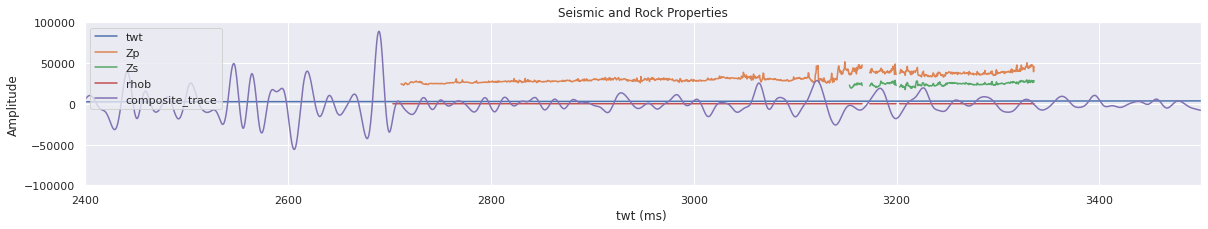

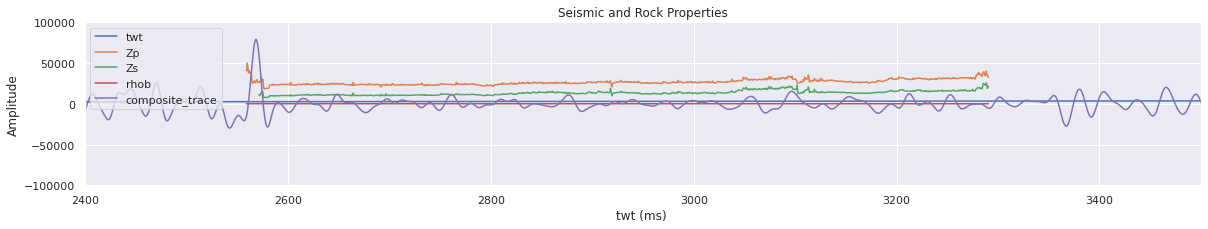

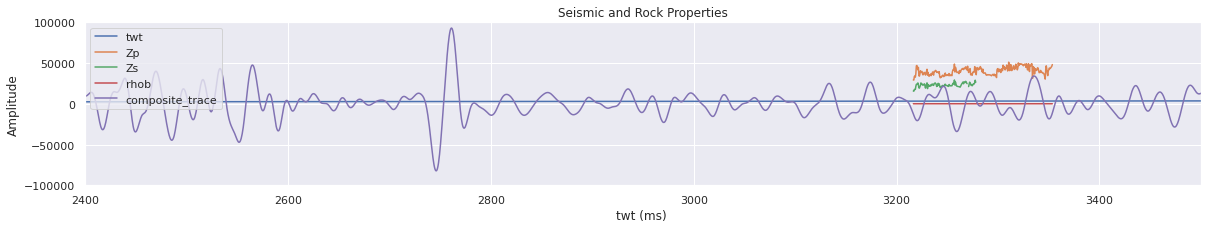

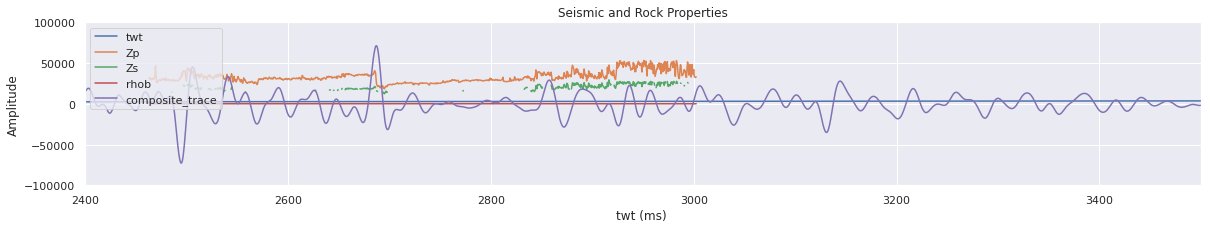

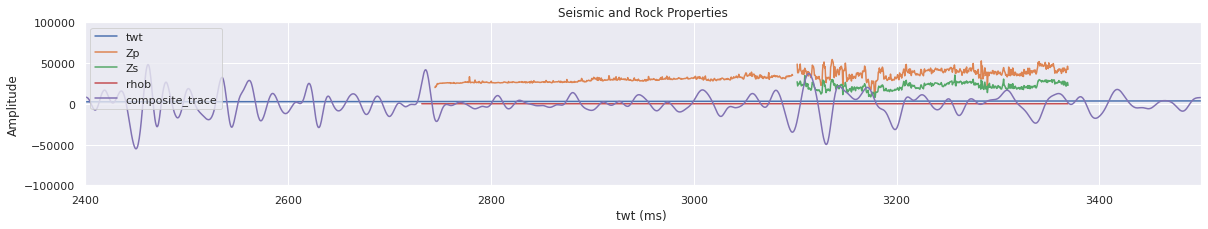

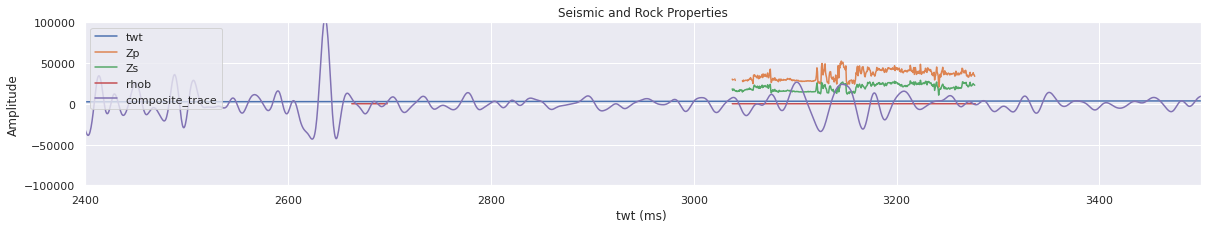

In [15]:
for tt_wells in tt_independent_wells:
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(0,6000.5,.5), tt_wells[:])
    plt.title('Seismic and Rock Properties')
    plt.ylim(-100000,100000)
    plt.xlim(2400,3500)
    plt.xlabel('twt (ms) ')
    plt.ylabel('Amplitude')
    plt.legend(loc='upper left', labels =['twt','Zp','Zs','rhob','composite_trace'])

Now let's play around with a few basic features that we can try to generate for training. Well start with a single well to illustrate an example and then we will loop through the rest of the wells to do it automatically. 

We will leave "twt" as a feature but you could consider developing another method for giving your models "depth" awareness. For instance, using horizons, or some other feature that is calculated from horizons and "twt" values.

#### Let's calculate trailing and leading (i.e. lagged) derivative features
Let's call these 'GradTrail' and 'GradLead'

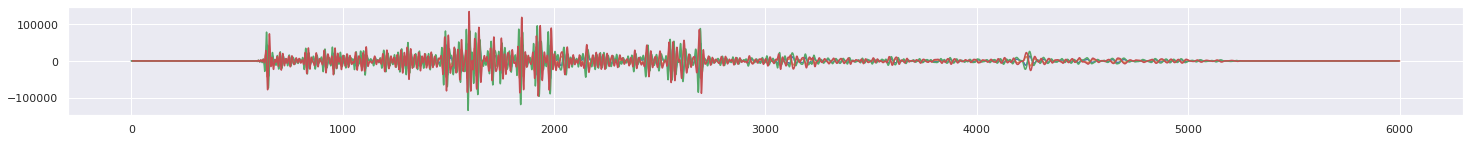

In [16]:
#create feature
well_01_tt['GradTrail5']  = well_01_tt['composite_trace'].diff(periods=-5)
well_01_tt['GradLead5']   = well_01_tt['composite_trace'].diff(periods=5)
well_01_tt['GradTrail10'] = well_01_tt['composite_trace'].diff(periods=-10)
well_01_tt['GradLead10']  = well_01_tt['composite_trace'].diff(periods=10)
#plot for QC
plt.figure(figsize=(25,2))
lines = plt.plot(np.arange(0,6000.5,.5), well_01_tt[['GradTrail5','GradLead5','GradTrail10','GradLead10']])

#### Let's calculate the Hilbert Transform "Envelope" and "Envelope Weighted Cosine of Instantaneous Phase" attributes of the Composite Seismic 
Let's call them `'HTEnv'` and `'HTEnvCosPhs'`.

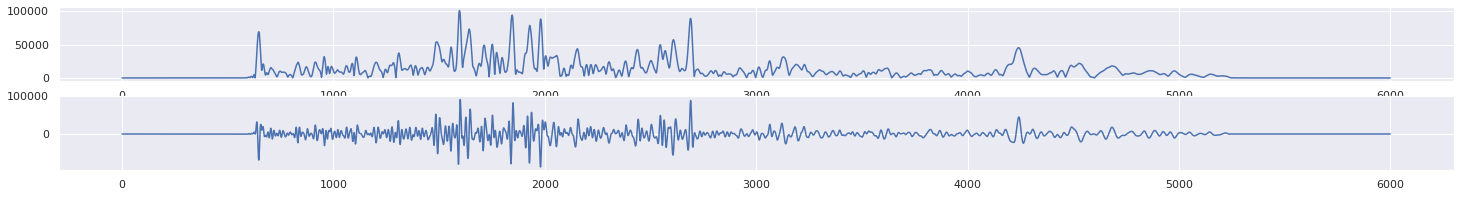

In [17]:
# Create features
analytic_signal = hilbert(well_01_tt['composite_trace'])
well_01_tt['HTEnv'] = np.abs(analytic_signal)
well_01_tt['HTEnvCosPhs'] = np.cos(np.angle(analytic_signal)) * well_01_tt['HTEnv']

# Plot for QC
fig, ax = plt.subplots(2, 1, figsize=(25,3))
line0 = ax[0].plot(np.arange(0,6000.5,.5), well_01_tt['HTEnv'])
line1 = ax[1].plot(np.arange(0,6000.5,.5), well_01_tt['HTEnvCosPhs'])

#### Now let's drop all of the rows with NaNs

You are welcome to interpolate the small gaps or find other ways to interpolate


In [18]:
#drop rows with nans
well_01_tt_f = well_01_tt.dropna()

#Now, lets check out our finalized training table 
well_01_tt_f.head()

,twt,Zp,Zs,rhob,composite_trace,GradTrail5,GradLead5,GradTrail10,GradLead10,HTEnv,HTEnvCosPhs
well_name,,,,,,,,,,,
well_01,3153.5,37061.358619,22785.667590,2.6977,-2001.303012,441.797588,1923.810917,2409.608950,6440.035204,6385.248929,-2001.303012
well_01,3154.0,35354.068894,21394.079211,2.6773,-1923.037918,827.887656,1400.231884,2953.280464,5426.531910,5778.058027,-1923.037918
well_01,3154.5,35977.475724,19578.838348,2.6617,-1933.998110,1178.973449,896.581681,3405.185903,4414.342008,5235.941644,-1933.998110
well_01,3155.0,37656.149932,19371.997677,2.6753,-2028.270606,1489.615584,420.890362,3759.885886,3413.101567,4775.052967,-2028.270606
well_01,3155.5,36089.365950,19873.146636,2.6642,-2199.942429,1754.374682,-25.236061,4012.457533,2432.446652,4415.159771,-2199.942429


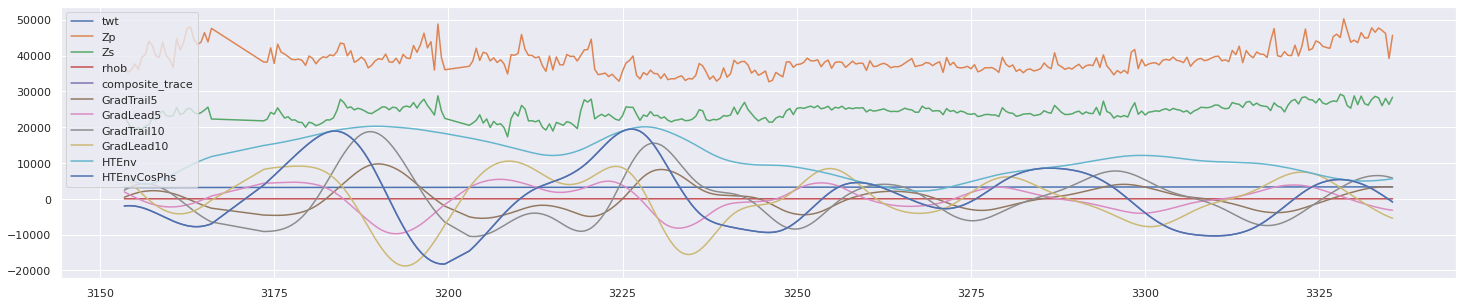

In [19]:
check = well_01_tt_f.reset_index()
plt.figure(figsize=(25,5))
plt.plot(check['twt'], check[['twt', 
                              'Zp', 'Zs', 'rhob',
                              'composite_trace',
                              'GradTrail5', 'GradLead5', 'GradTrail10', 'GradLead10',
                              'HTEnv', 'HTEnvCosPhs']])

plt.legend(loc='upper left', labels =['twt', 
                                      'Zp', 'Zs', 'rhob',
                                      'composite_trace',
                                      'GradTrail5', 'GradLead5', 'GradTrail10', 'GradLead10',
                                      'HTEnv', 'HTEnvCosPhs']);

Now let's loop through all of the wells and generate these features. 

In [20]:
for tt_well in tt_independent_wells:
    tt_well['GradTrail5'] = tt_well['composite_trace'].diff(periods=-5)
    tt_well['GradLead5'] = tt_well['composite_trace'].diff(periods=5)
    tt_well['GradTrail10'] = tt_well['composite_trace'].diff(periods=-10)
    tt_well['GradLead10'] = tt_well['composite_trace'].diff(periods=10)
    tt_well['HTEnv'] = np.abs(hilbert(tt_well['composite_trace']))

#### Now let's make one big training table from all of our wells - we will leave one of the wells out to use as a testing well for Blind Testing

In this section, you can play with the wells used in the training versus what is reserved for testing.

We will be doing the final evaluation on completely different set of wells (2 wells).

In [21]:
training_wells = [well_01_tt, well_11_tt, well_21_tt, well_25_tt, well_27_tt]
testing_well = [well_33_tt]

We will now concatenate all of the wells in the training dataset and seperate into X_train (inputs) and y_train (targets) & X_test (inputs) and y_test (targets). We will also shuffle the data because the keras fit functions will take a percentage from the bottom of the dataset and reserve it for validation. If we don't shuffle, then we will only be validating on data from the last well in the dataframe.  

In [22]:
features = ['twt','composite_trace','GradTrail5','GradLead5','GradTrail10','GradLead10','HTEnv']
targets = ['Zp','Zs','rhob']

# Here we concat all of the training wells and drop rows with nans
training_wells_tt = pd.concat(training_wells)
training_wells_tt = training_wells_tt.dropna()

# Here we shuffle the data
training_wells_tt = training_wells_tt.sample(frac=1)

# Here we seperate into inputs and targets 
X_train = training_wells_tt[features]
y_train = training_wells_tt[targets]

# Print for QC
print('training inputs:', X_train)
print('training targets:',y_train)

# Here we drop rows with nans in testing data
testing_well_tt = testing_well[0]
testing_well_tt = testing_well_tt.dropna()

# Here we seperate into inputs and targets 
X_test = testing_well_tt[features]
y_test = testing_well_tt[targets]

# Print for QC
print('testing inputs:', X_test)
print('testing targets:',y_test)

training inputs:               twt  composite_trace   GradTrail5    GradLead5   GradTrail10  \
well_name                                                                    
well_01    3291.0      7386.620787  1931.720587  -928.523437   5003.158635   
well_01    3324.0      3390.514205 -1745.671964  3249.215295  -1844.151595   
well_01    3221.5     13088.995205 -4619.498414  4449.979320  -6373.339794   
well_01    3163.5     -7765.516939  -778.395842 -1162.372376  -3398.637791   
well_01    3190.0      5745.136277  9754.394083 -8242.042427  18127.701786   
...           ...              ...          ...          ...           ...   
well_01    3185.0     18362.618521  4375.439817  -133.845553  12617.482244   
well_01    3211.5      1725.932894 -2344.210280  3923.034549  -4167.713116   
well_01    3273.5     -2023.809814 -2359.761693   718.679112  -5569.457589   
well_01    3292.0      6752.548918  2392.609778 -1287.283072   5890.749200   
well_01    3155.5     -2199.942429  1754.374682

Let's look at the testing well data 

# Section 2. Data Preparation for ML Model Training

#### Building and training a Neural Network using Keras-Tensorflow

##### Some basic normalzation is recommened for the deep learning schema, here we explore the use of minmax normalization 

Let's create a simple function to help us with this. This function returns two things: the scaled dataset (scaled_data) and the scaler for using to inverse transfomr the data (scaler)

In [23]:
def minmax_scaler(data, minmaxrange=(-1,1)):
    scaler = MinMaxScaler(feature_range = minmaxrange)
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

You have to keep in mind that for scaling and rescaling data, you have to use your training scalers. 

In [24]:
# Here we scale the training inputs and create the scaler to be used to scale testing data and for inverse transform after simulation
X_train_scaled, X_scaler = minmax_scaler(X_train, minmaxrange=(-1,1))
X_test_scaled = X_scaler.transform(X_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Here we do the same for the targets
y_train_scaled, y_scaler = minmax_scaler(y_train, minmaxrange=(-1,1))
y_test_scaled = y_scaler.transform(y_test)

# Scaling converts dataframes to numpy arrays automatically so we want to convert back to pandas dataframe
y_train_scaled = pd.DataFrame(y_train_scaled, index=y_train.index, columns=y_train.columns)
y_test_scaled = pd.DataFrame(y_test_scaled, index=y_test.index, columns=y_test.columns)

Now lets take a quick look at our scaled data, we should see values between -1 and 1. Each feature is scaled independent of the rest. Below is an example of what the training inputs look like now. 

In [25]:
X_train_scaled.head(5)

,twt,composite_trace,GradTrail5,GradLead5,GradTrail10,GradLead10,HTEnv
well_name,,,,,,,
well_01,0.510989,0.358891,-0.029538,0.161568,0.060869,0.200187,-0.127884
well_01,0.873626,0.146735,-0.513517,0.711398,-0.407013,0.766825,-0.452269
well_01,-0.252747,0.661634,-0.891740,0.869430,-0.716496,0.772665,0.532888
well_01,-0.890110,-0.445548,-0.386215,0.130791,-0.513233,0.051778,-0.153113
well_01,-0.598901,0.271743,1.000000,-0.800960,0.957678,-0.581161,0.999470


# Section 3. Neural Network Model Training

Up to this point, the workflow should be the same regardless of the type of machine learning model you want to use. We will use a keras-tensorflow neural network approach for this part. 

Here we will design our neural network architecture. You can use this webapp to visualize various NN architectures: http://alexlenail.me/NN-SVG/index.html

The model below is a Sequential Model: A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. Learn more about Sequential Models here: https://keras.io/guides/sequential_model/

**Architecture:**
- 8 input Neurons 
- 2 Hidden Layers w/ 32 neurons each 
- 3 Outputs 

**Hyperparameters:**
- Hidden Layer has ReLu Activation
- Output Layer has Linear Activation
- Adam Optimizer
- MSE as loss metric 
- EarlyStopping is active w/ Patience = 30 
- Batch Size is 256 
- 50% of data is reserved for validation 
- Training with a MAX of 5000 Epochs

In [33]:
# %%time
# Train models and keep them in memory 
# This is where we define the amount of models in the ensemble
# We save those models to a list 'models'
n_members = 5
model_store = []

# We store our training performance in 'history_store'
history_store = []

#here we define model architecture and train the neural network in a loop for each model 
for i in range(n_members): 
    model = Sequential()
    
    # Adding layers
    model.add(layers.Dense(32, activation='relu', input_dim=X_train_scaled.shape[1], kernel_initializer='he_uniform'))
    model.add(layers.Dense(32, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(y_train_scaled.shape[1], activation='linear'))
    
    # Setting optimizer
    opt = keras.optimizers.Adam(learning_rate=0.001)
    
    # Compile model and add callbacks
    model.compile(optimizer=opt, loss='mse')
    callbacks = [k.callbacks.EarlyStopping(monitor='loss', patience=30)]
    
    # Fit and save! 
    history_store.append(model.fit(X_train_scaled, 
                                   y_train_scaled, 
                                   epochs=5000, validation_split=0.5,
                                   shuffle=True, batch_size=256, callbacks=callbacks,
                                   verbose=0))
    model_store.append(model)
    
    # Some basic print statements for updating us during training
    loss = history_store[i].history['loss']
    epochs = range(len(loss))
    print('-------------------------------------------------- Completed Training of Model #', i)
    print('-------------------------------------------------- Total Epochs Range:', epochs )
    print('-----------------------------------------------------------------------------------')

-------------------------------------------------- Completed Training of Model # 0
-------------------------------------------------- Total Epochs Range: range(0, 5000)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 1
-------------------------------------------------- Total Epochs Range: range(0, 5000)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 2
-------------------------------------------------- Total Epochs Range: range(0, 5000)
-----------------------------------------------------------------------------------
-------------------------------------------------- Completed Training of Model # 3
-------------------------------------------------- Total Epochs Range: range(0, 5000)
------------------------------------------------------------------------

Here we visualize the performance for each model starting with model #1. We want to interpret these and try to see how to adjust our model architecture and hyperparameters to improve the learning process. 

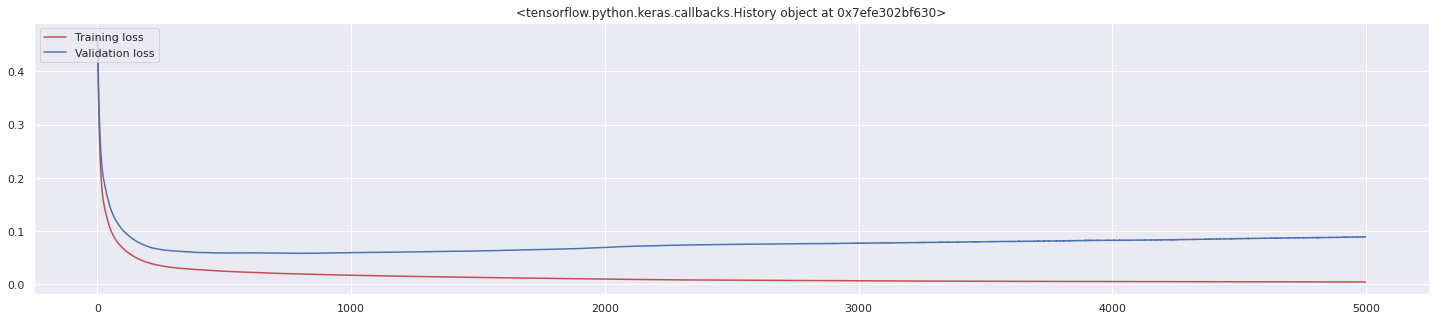

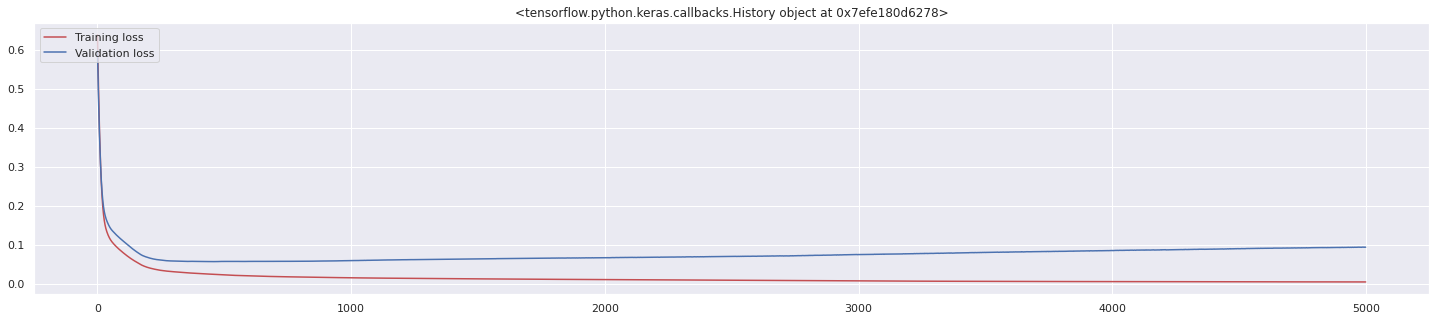

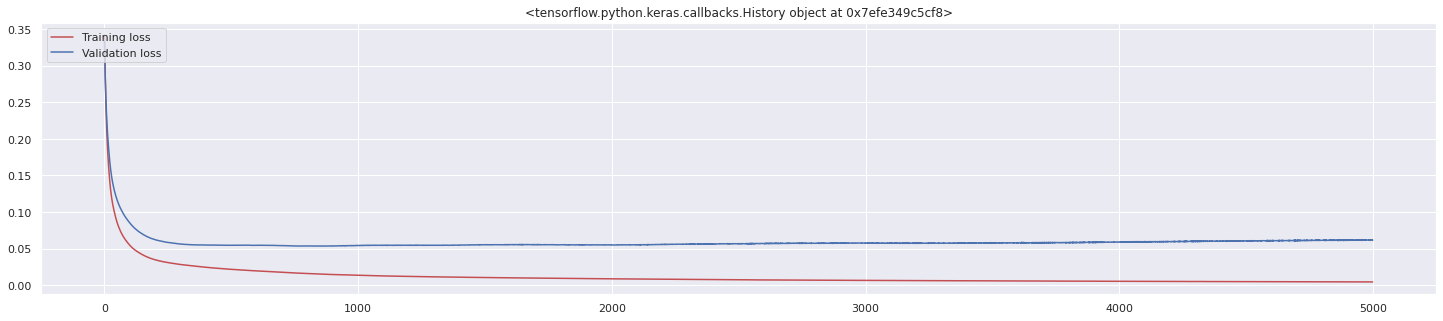

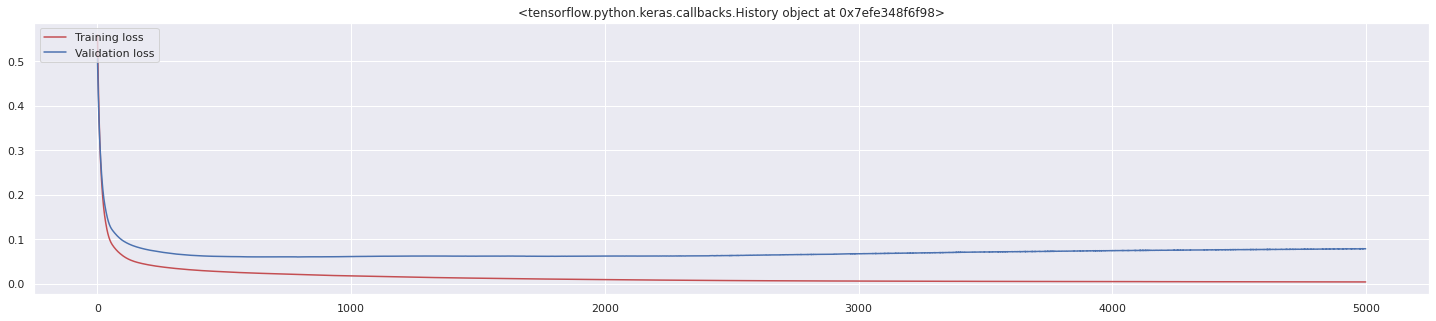

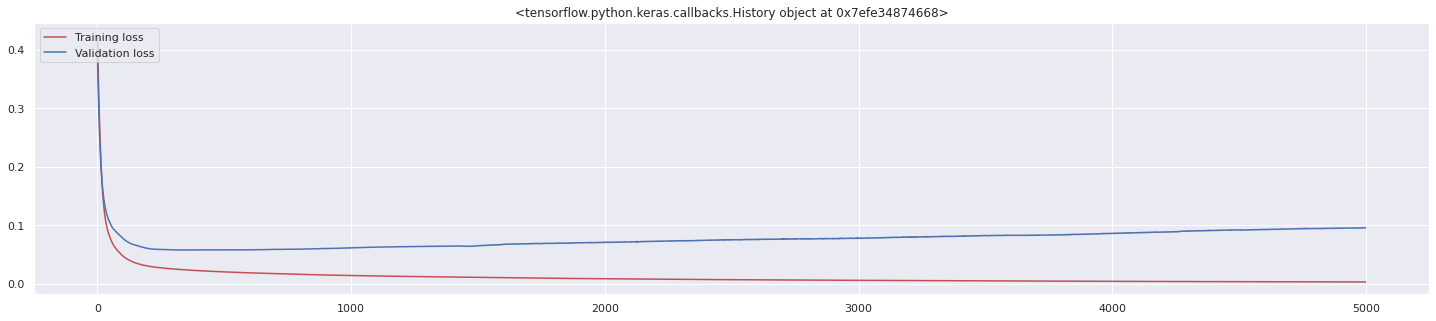

In [34]:
for history in history_store:
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure(figsize=(25,5))
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.legend(loc='upper left')
    plt.title(str(history))

# Section 4. Bootstrap Aggregation and Inference

**Bootstrap aggregation (bagging)** is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach.

Learn more about Ensembling NNs here: https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

In [35]:
yhats = [y_scaler.inverse_transform(model.predict(X_test_scaled)) for model in model_store]
yhats = np.array(yhats)

In [36]:
Zp_ensemble = yhats[:,:,0].mean(0)
Zs_ensemble = yhats[:,:,1].mean(0)
Rhob_ensemble = yhats[:,:,2].mean(0)

In [38]:
Results = y_test.copy()
Results['Zp_Prediction'] = Zp_ensemble
Results['Zs_Prediction'] = Zs_ensemble
Results['Rhob_Prediction'] = Rhob_ensemble
Results['twt'] = X_test['twt']
Results = Results.reset_index()
Results

,well_name,Zp,Zs,rhob,Zp_Prediction,Zs_Prediction,Rhob_Prediction,twt
0,well_33,30170.712683,18177.815140,2.2705,39283.726562,17099.712891,2.957679,3038.0
1,well_33,29173.007638,16367.512751,2.2486,39793.445312,17006.837891,2.949654,3038.5
2,well_33,29640.355087,17413.894150,2.2047,40417.429688,17059.296875,2.930436,3039.0
3,well_33,30388.937556,16143.283957,2.2618,44895.398438,20541.671875,2.951551,3040.5
4,well_33,28611.563104,16002.872511,2.2507,46150.414062,21935.623047,2.978505,3041.0
...,...,...,...,...,...,...,...,...
459,well_33,35670.487327,24008.216842,2.4520,38621.476562,23866.566406,2.478345,3275.0
460,well_33,38100.632885,24697.457586,2.5694,38578.937500,23790.738281,2.479831,3275.5
461,well_33,35727.080956,23617.950301,2.5828,38429.058594,23666.460938,2.484126,3276.0
462,well_33,35371.186020,23286.449833,2.4341,38094.136719,23550.558594,2.490711,3276.5


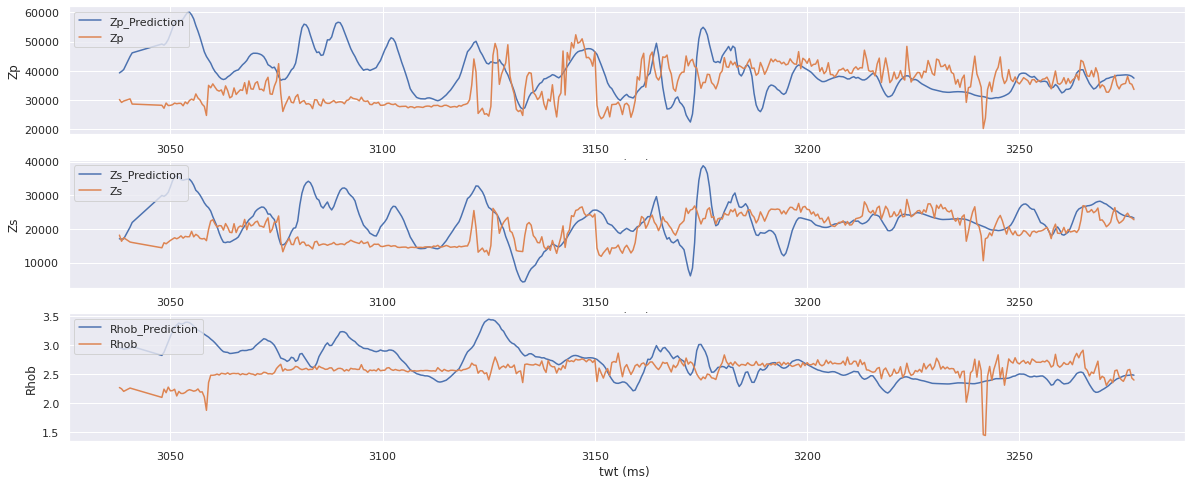

In [39]:
plt.figure(figsize=(20,8))
plt.subplot(311)
plt.plot(Results['twt'],Results[['Zp_Prediction','Zp']])
plt.legend(loc='upper left', labels =['Zp_Prediction','Zp'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zp')
plt.subplot(312)
plt.plot(Results['twt'],Results[['Zs_Prediction','Zs']])
plt.legend(loc='upper left', labels =['Zs_Prediction','Zs'])
plt.xlabel('twt (ms) ')
plt.ylabel('Zs')
plt.subplot(313)
plt.plot(Results['twt'],Results[['Rhob_Prediction','rhob']])
plt.legend(loc='upper left', labels =['Rhob_Prediction','Rhob'])
plt.xlabel('twt (ms) ')
plt.ylabel('Rhob')
plt.show();

# Conclusions

This scheme was only meant to give you a taste of what a basic workflow would look like. We recommend that you spend time researching methods to improve on these results. You didn't think we would give you the answer did you? However, this could help set the foundation if you are currently struggling to get started. 

**What did we do:** We used the work from a previous notebook to retrieve S3 seismic data using real-simple-seismic (rss) and extracting the traces along the wellbore of each well. We then used the data at the wellbore to do some basic feature engineering, build training and testing datatsets, prepare those datasets for a deep learning scheme, trained a vanilla NN model, and infered on blind (out of sample) data.

High Level Comments: 
- A neural networks may or may not be the best solution to this problem. You could try a different kind of machine learning algorithm. 
- We are definitely not doing any advanced feature engineering here. There is a ton of room for improvement here. 
- There is hardly any model optimization here. You could try using GridSearchCV to optimize hyperparameters. 
- We are not doing any input selection - there are various methods that could help with this suchas recursive input selection or stochastic removal of inputs
- Data augmentation - there is quite a problem with data sparsity in this dataset. We expect that teams that spend time on data augmentations are likely to see massive uplift in solution accuracy. 